# Проект: Рекомендация тарифов

**Цели проекта:** 

- Нужно построить модель для задачи классификации, которая выберет подходящий тариф.
- Построить модель с максимально большим значением *accuracy* (> 0.75) на тестовой выборке.

# План проекта:

1. Открыть и изучить файл с данными
2. Разбить данные на обучающую, валидационную и тестовую выборки
3. Исследовать модели классификации тарифов
4. Проверить модели на тестовой выборке
5. Проверить адекватность модели
6. Общий вывод

# Описание данных:
Каждый объект в наборе данных users_behavior.csv — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

**Импортируем библиотеки:**

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [34]:
# открываем и смотрим файл
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [35]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Медиана и среднее значение параметров отличаются незначительно.

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [37]:
df.duplicated().sum()

0

Посмотрим на параметры, пропишем составную функцию check_param

In [38]:
#прописываем функцию построения гистограммы
def hist_builder(data_column, label, bins):
    sns.set()
    f, axes = plt.subplots(1,2,figsize=(20,10))
    axes[0].set_title("Плотность распределения для параметра: " + label, fontsize=20)
    axes[0].set_ylabel("Плотность параметра: " + label, fontsize = 18)
    axes[0].set_xlabel("Параметр: " + label, fontsize = 18)
    sns.distplot(data_column, axlabel= "Параметр: " + label, bins=bins, ax=axes[0])
    axes[1].set_title("Boxplot для параметра: " + label, fontsize=18)
    axes[1].set_xlabel("Параметр: " + label, fontsize = 18)
    sns.boxplot(data = data_column, orient="h", ax=axes[1])
    plt.show()
#прописываем функцию поиска аномалий
def anomaly_detection(data_column, label):
    anomaly_threshold = data_column.quantile(0.75) + (data_column.quantile(0.75) - data_column.quantile(0.25)) * 1.5
    anomaly_percent = round(len(data_column[data_column > anomaly_threshold]) / len(data_column) * 100, 2)
    print("Доля выбросов параметра '" + label + "' равно: " + str(anomaly_percent) + "%")
#прописываем итоговую функцию    
def check_param(data_column, label, bins):
    hist_builder(data_column, label, bins)
    anomaly_detection(data_column, label)

Анализ параметра 'calls':


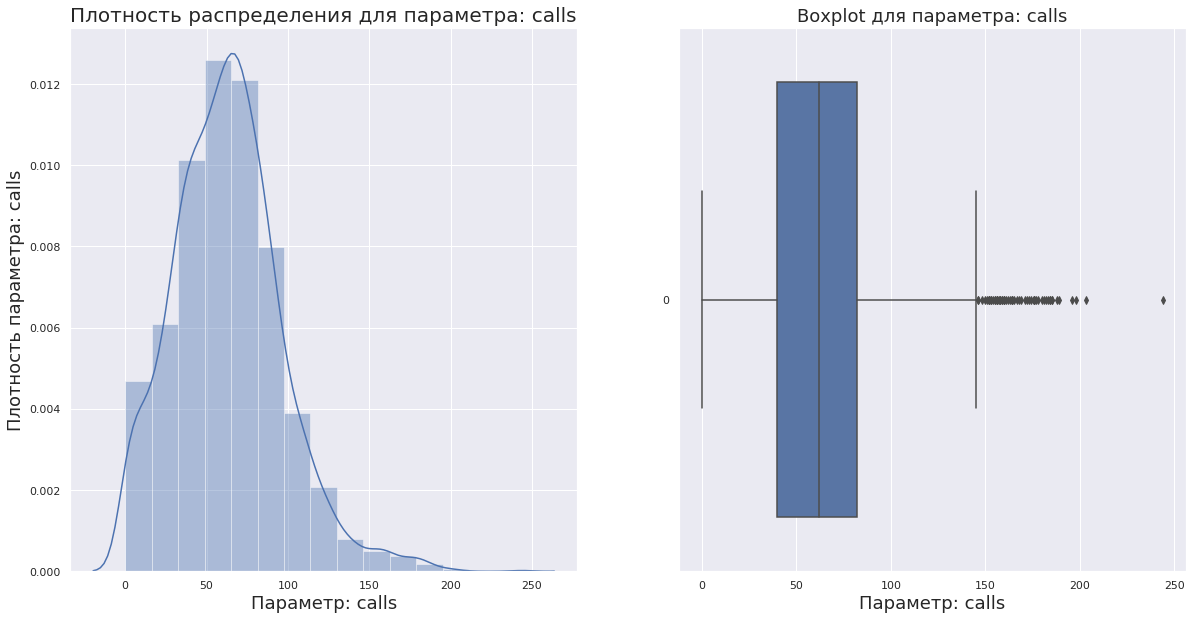

Доля выбросов параметра 'calls' равно: 1.93%
Анализ параметра 'minutes':


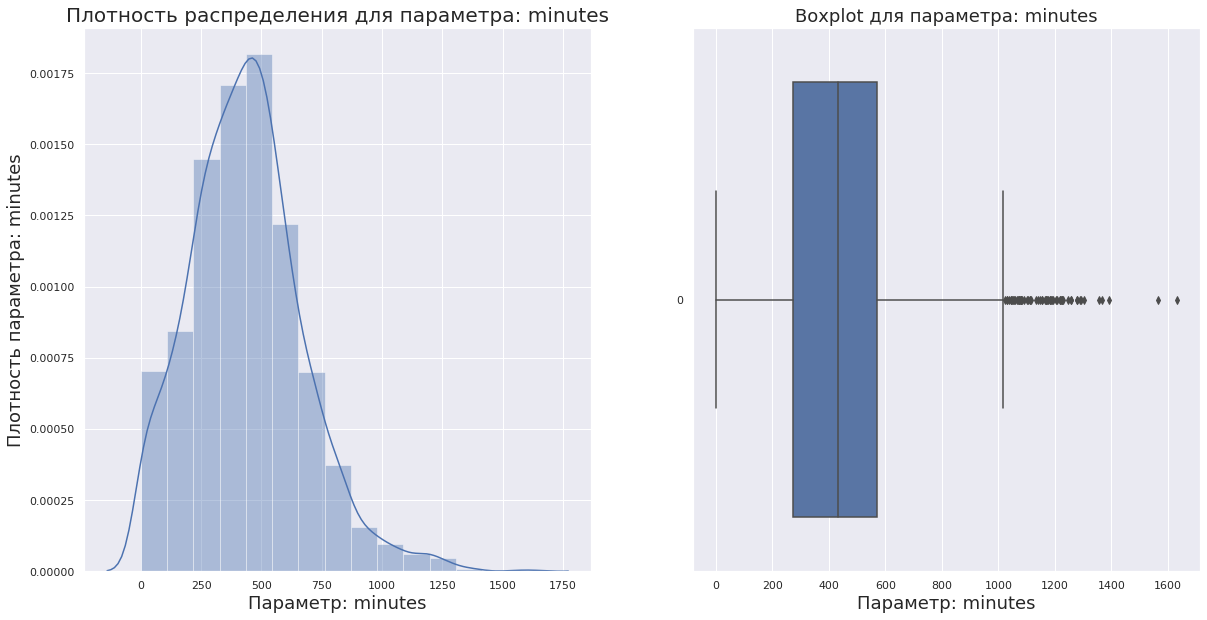

Доля выбросов параметра 'minutes' равно: 1.9%
Анализ параметра 'messages':


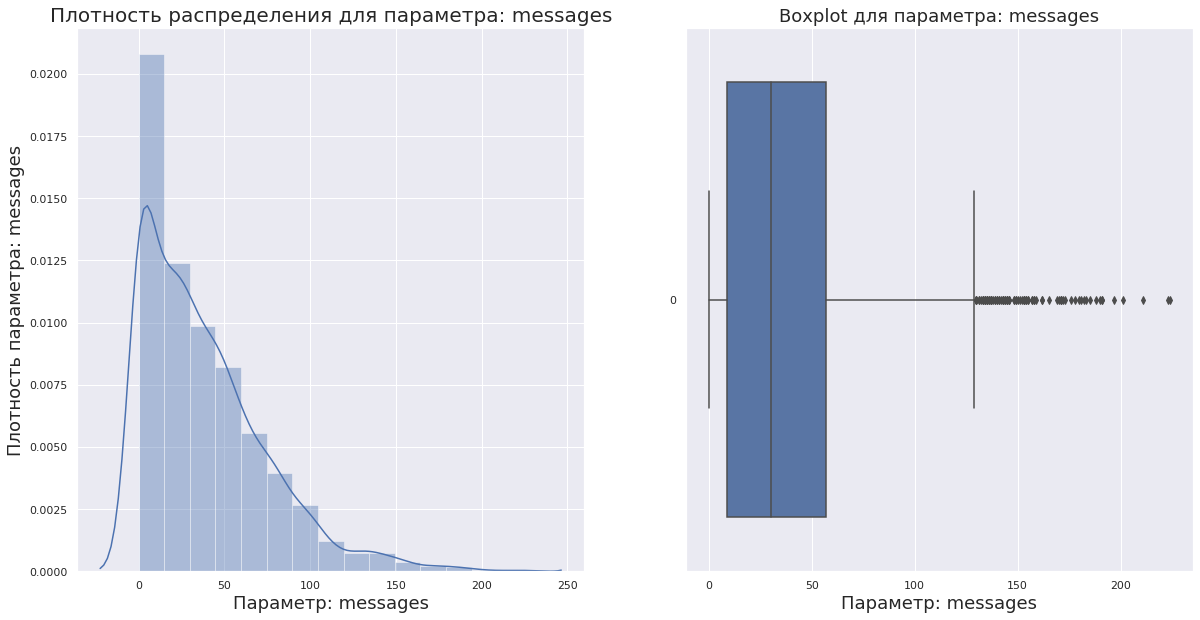

Доля выбросов параметра 'messages' равно: 2.83%
Анализ параметра 'mb_used':


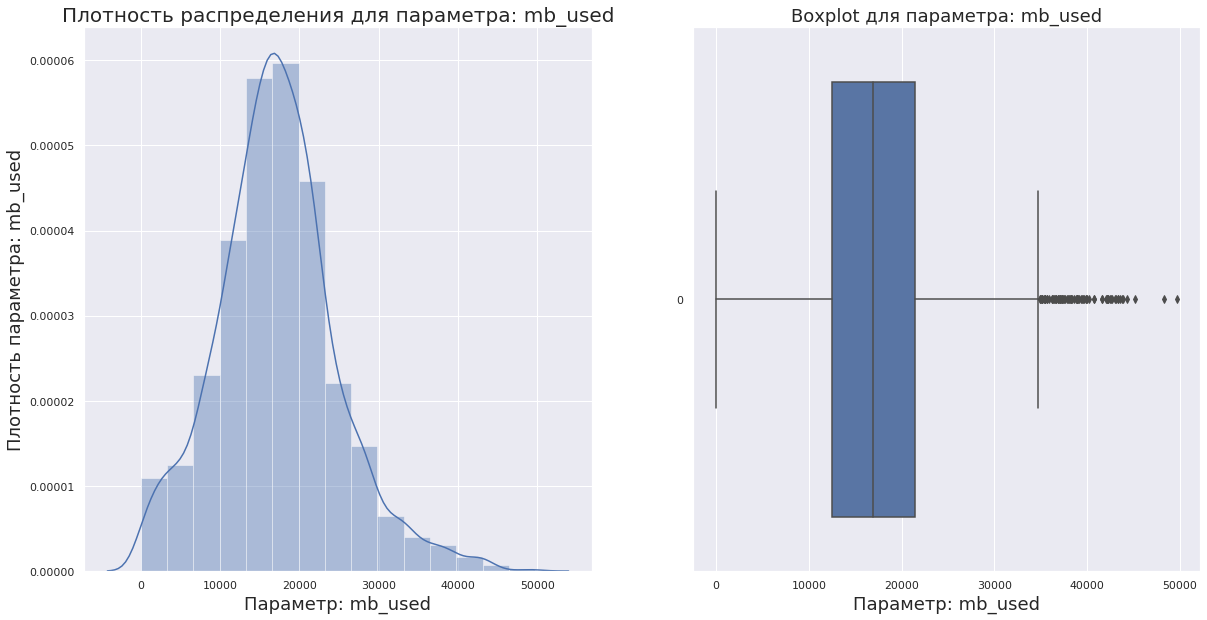

Доля выбросов параметра 'mb_used' равно: 2.4%


In [39]:
#вызываем функцию
for column in df.drop(['is_ultra'], axis=1).columns:
    print("Анализ параметра '" + column + "':")
    check_param(df[column], column, bins=15)

- Выбросы по параметрам колеблются от 1.9 - 2.4%. Не будем удалять эти данные. 
- Заметен нулевой пик в столбце messages.

**Выводы по первому пункту проекта:**

- Данные открыты и изучены. Всего имеется 3214 записей, без пропусков, без дубликатов.
- Не наблюдаем существенного различия между средним значением и медианой параметров 
- Выбросы по параметрам колеблются от 1.9 - 2.4%.
- Заметен нулевой пик в столбце messages.
    

## Разбейте данные на выборки

- Размер обучающей, валидационной и тестовой выборок: 60, 20, 20%.
- Признаки (features) проекта: calls, minutes, messages, mb_used
- Целевой признак (target) проекта: is_ultra

In [40]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [41]:
features_rest, features_test, target_rest, target_test = train_test_split(features,
                                                                         target,
                                                                         test_size=0.2,
                                                                         random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(features_rest,
                                                                         target_rest,
                                                                         test_size=0.25,
                                                                         random_state=12345)

In [42]:
print("Размер обучающей выборки. Признаки: ", features_train.shape, "Целевой признак: ", target_train.shape);
print("Размер валидационной выборки. Признаки: ", features_valid.shape, "Целевой признак: ", target_valid.shape);
print("Размер тестовой выборки. Признаки: ", features_test.shape, "Целевой признак: ", target_test.shape);

Размер обучающей выборки. Признаки:  (1928, 4) Целевой признак:  (1928,)
Размер валидационной выборки. Признаки:  (643, 4) Целевой признак:  (643,)
Размер тестовой выборки. Признаки:  (643, 4) Целевой признак:  (643,)


## Исследуйте модели

Оценивать модели классификации для проекта будем по метрике общей точности accuracy

### Модель №1: Решающее дерево

Гиперпараметры модели:
- max_depth - максимальная глубина дерева
- min_samples_split - минимальное количество примеров для разделения
- min_samples_leaf - минимальное количество объектов в листе
- criterion - функция качества деления (Gini impurity / Entropy) - используем Gini   

In [43]:
#обучаем и оцениваем модель
best_model_params = []
best_accuracy = 0

for depth in range(2,10):
    for samples_split in range(2,10):
        for samples_leaf in range(1,10):
            model = DecisionTreeClassifier(random_state=12345,
                                          max_depth=depth,
                                          min_samples_split=samples_split,
                                          min_samples_leaf=samples_leaf,
                                          criterion='gini')
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            accuracy = accuracy_score(target_valid, predictions)
            
            if accuracy > best_accuracy:
                best_model_params = [depth, samples_split, samples_leaf]
                best_accuracy = accuracy

In [44]:
print("Лучшая точность для решающего дерева равна: {0}, \n"
      "Параметры этого дерева:\n"
      "Макс. Глубина: {1} \n"
      "Мин. количество примеров для разделения: {2} \n"
      "Мин. кол-во объектов в листе: {3}"
     .format(round(best_accuracy, 2), best_model_params[0], best_model_params[1], best_model_params[2]))

Лучшая точность для решающего дерева равна: 0.79, 
Параметры этого дерева:
Макс. Глубина: 7 
Мин. количество примеров для разделения: 2 
Мин. кол-во объектов в листе: 8


In [45]:
if (best_accuracy > 0.75):
    print("Точность больше 75%. Модель подходит по условиям задачи")
else:
    print("Точность меньше 75%. Модель не подходит по условиям задачи")

Точность больше 75%. Модель подходит по условиям задачи


### Модель №2: Случайный лес

Гиперпараметры модели:
- max_depth - максимальная глубина дерева
- min_samples_split - минимальное количество примеров для разделения
- min_samples_leaf - минимальное количество объектов в листе
- n_estimators - количество деревьев в лесу
- criterion - функция качества деления (Gini impurity / Entropy) - используем Gini   

In [46]:
#обучаем и оцениваем модель
best_model_params = []
best_accuracy = 0

for depth in range(2,10):
    for est in range(1,10):
        for samples_split in range(2,10):
            for samples_leaf in range(1,10):
                model = RandomForestClassifier(random_state=12345,
                                              max_depth=depth,
                                              n_estimators=est,
                                              min_samples_split=samples_split,
                                              min_samples_leaf=samples_leaf,
                                              criterion='gini')
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                accuracy = accuracy_score(target_valid, predictions)

                if accuracy > best_accuracy:
                    best_model_params = [depth, samples_split, samples_leaf, est]
                    best_accuracy = accuracy

In [47]:
print("Лучшая точность для решающего дерева равна: {0}, \n"
      "Параметры этого леса:\n"
      "Макс. Глубина: {1} \n"
      "Мин. количество примеров для разделения: {2} \n"
      "Мин. кол-во объектов в листе: {3} \n"
      "Количество деревьев: {4}"
     .format(round(best_accuracy, 2), best_model_params[0], best_model_params[1], best_model_params[2], best_model_params[3]))

Лучшая точность для решающего дерева равна: 0.81, 
Параметры этого леса:
Макс. Глубина: 8 
Мин. количество примеров для разделения: 3 
Мин. кол-во объектов в листе: 1 
Количество деревьев: 3


In [48]:
if (best_accuracy > 0.75):
    print("Точность больше 75%. Модель подходит по условиям задачи")
else:
    print("Точность меньше 75%. Модель не подходит по условиям задачи")

Точность больше 75%. Модель подходит по условиям задачи


### Модель №3: Логистическая регрессия

Гиперпараметры модели:
- C - инверсия силы регуляризации (малые значения -> модель недостаточно "штрафуется" за ошибки. Большие значения -> модель "боится ошибиться" и стремится к переобучению)
- max_iter - число итераций, прежде чем будет достигнут критерий останова. (так как наилучшая точность не отличается, если использовать гиперпараметр по умолчанию, не будем использовать этот гиперпараметр)
- solver - алгоритм оптимизации проблемы (для небольшого датасета используем liblinear)

In [49]:
#обучаем и оцениваем модель
best_model_params = []
best_accuracy = 0

for C_cur in np.linspace(0.01,3,500):
    #for n_iter in range(50,300):
        model = LogisticRegression(random_state=12345,
                                   C=C_cur,
                                  solver= 'liblinear')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)

        if accuracy > best_accuracy:
            best_model_params = [C_cur]
            best_accuracy = accuracy

In [50]:
print("Лучшая точность для логистической регрессии равна: {0}, \n"
      "Параметры модели логистической регрессии:\n"
      "Инверсия силы регуляризации: {1} \n"
     .format(round(best_accuracy, 2), round(best_model_params[0], 2)))

Лучшая точность для логистической регрессии равна: 0.73, 
Параметры модели логистической регрессии:
Инверсия силы регуляризации: 0.12 



In [51]:
if (best_accuracy > 0.75):
    print("Точность больше 75%. Модель подходит по условиям задачи")
else:
    print("Точность меньше 75%. Модель не подходит по условиям задачи")

Точность меньше 75%. Модель не подходит по условиям задачи


### Модель №4: K - ближайших соседей

Гиперпараметры модели:
- n_neighbors - число "центров" или "соседей"

In [52]:
#обучаем и оцениваем модель
best_model_params = []
best_accuracy = 0

for n_neighbors_cur in range(1,20):
        model = KNeighborsClassifier(n_neighbors=n_neighbors_cur)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        accuracy = accuracy_score(target_valid, predictions)

        if accuracy > best_accuracy:
            best_model_params = [n_neighbors_cur]
            best_accuracy = accuracy

In [53]:
print("Лучшая точность для KNN равна: {0}, \n"
      "Параметры модели KNN:\n"
      "Число соседей: {1} \n"
     .format(round(best_accuracy, 2), best_model_params[0]))

Лучшая точность для KNN равна: 0.77, 
Параметры модели KNN:
Число соседей: 12 



In [54]:
if (best_accuracy > 0.75):
    print("Точность больше 75%. Модель подходит по условиям задачи")
else:
    print("Точность меньше 75%. Модель не подходит по условиям задачи")

Точность больше 75%. Модель подходит по условиям задачи


**Итого точности моделей примерно составляют:**
- 81% -> Случайный лес
- 79% -> Решающее дерево
- 77% -> K-случайных соседей
- 73% -> Логистическая регрессия

Для пункта 4 будем проверять модель случайного леса уже на тестовой выборке.

**Гиперпараметры случайного леса:**

- Макс. Глубина: 8 
- Мин. количество примеров для разделения: 3 
- Мин. кол-во объектов в листе: 1 
- Количество деревьев: 3

## Проверьте модель на тестовой выборке

In [55]:
#обучаем и оцениваем модель
best_model_params = []
best_accuracy = 0

model = RandomForestClassifier(random_state=12345,
                              max_depth=8,
                              n_estimators=3,
                              min_samples_split=3,
                              min_samples_leaf=1,
                              criterion='gini')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print("Точность модели на тестовой выборке составляет: ", round(accuracy, 3))

Точность модели на тестовой выборке составляет:  0.793


In [56]:
if (accuracy > 0.75):
    print("Точность больше 75%. Модель подходит по условиям задачи")
else:
    print("Точность меньше 75%. Модель не подходит по условиям задачи")

Точность больше 75%. Модель подходит по условиям задачи


Итого наблюдаем точность на тестовой выборке (79.3%) чуть меньшую, чем на валидационной выборке (около 81%). Так как точность выше 75%, принимаем данную модель.

## (бонус) Проверьте модели на адекватность

Точность модели больше 50%, значит предикт модели лучше, чем случайно выбранный тариф.

Проверка на адекватность также необходима чтобы понять, что модель "адекватно" пытается выявить закономерность в данных, а не просто выдавать ответ определенного образца, потому что его больше по объему в датасете. Если точность модели равна объему целевого признака определенной категории, то это дает повод задуматься.

Пример из жизни: разметка данных бурения скважин, с аварией = 1, без аварии = 0. Так как время нормального бурения значительно превышает время с авариями, модель может просто выдавать безаварийный режим в каждый момент времени и иметь высокую итоговую точность.

In [57]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

**Итого:**

- Точность модели (79.3%) больше 50%, значит предикт модели лучше, чем случайно выбранный тариф.
- Точность модели (79.3%) больше 69%, значит модель ведет себя адекватно не только с преобладающей категорией целевого признака.

Модель адекватна.

In [58]:
#используем DummyClassifier для проверки адекватности модели
best_model_params = []
best_accuracy = 0

model = DummyClassifier(strategy='most_frequent')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)
print("Точность модели на тестовой выборке составляет: ", round(accuracy, 3))

Точность модели на тестовой выборке составляет:  0.695


## Общий вывод

- Данные открыты и изучены. Всего имеется 3214 записей, без пропусков, без дубликатов.
- Не наблюдаем существенного различия между средним значением и медианой параметров 
- Выбросы по параметрам колеблются от 1.9 - 2.4%.
- Модель случайного леса с наилучим показателем точности (около 81%, по валидационной выборке) проверили на тестовой выборке.
- Точность модели случайного леса на тестовой выборке (79.3%) чуть меньше, чем на валидационной выборке (около 81%). Так как точность выше 75%, принимаем данную модель.
- Точность модели (79.3%) больше 50%, значит предикт модели лучше, чем случайно выбранный тариф. Точность модели (79.3%) больше 69% (объем целевого признака категории is_ultra=True) объем данных с , значит модель ведет себя адекватно не только с преобладающей категорией целевого признака. Следовательно, модель адекватна.

**Точности моделей на валидационной выборке примерно составляют:**
- 81% -> Случайный лес
- 79% -> Решающее дерево
- 77% -> K-случайных соседей
- 73% -> Логистическая регрессия

**Гиперпараметры случайного леса:**

- Макс. Глубина: 8 
- Мин. количество примеров для разделения: 3 
- Мин. кол-во объектов в листе: 1 
- Количество деревьев: 3
